# Multi-Asset Statistical Arbitrage Backtesting Engine

## Objective
This project builds a modular backtesting engine for
statistical arbitrage strategies across equities, ETFs, and FX.

The goal is not to maximize historical Sharpe, but to demonstrate:
- Trading intuition
- Statistical rigor
- Risk-aware system design
- Institutional-grade engineering practices

## Why This Project Exists

Most student trading projects:
- Mix research and execution logic
- Ignore transaction costs
- Use unrealistic assumptions
- Cannot scale beyond a single notebook

This project is explicitly designed to mirror how
systematic trading strategies are researched, validated,
and risk-managed in professional trading environments.

## High-Level System Architecture

Market Data
→ Research Layer (offline, slow, exploratory)
→ Signal Generation (deterministic, rule-based)
→ Portfolio Construction (capital allocation)
→ Execution Simulation (costs, slippage)
→ Risk Management (stops, exposure limits)
→ Performance Evaluation

Each component is isolated to prevent:
- Look-ahead bias
- Research leakage
- Overfitting

## Research vs Production Code Separation

Research notebooks are used only to:
- Explore data
- Test hypotheses
- Visualize distributions

All trading logic lives in Python modules
that can be unit-tested and reused.

---

# Phase 1: System Design & Architecture

## Objective

The goal of Phase 1 is to design a **backtesting system architecture** 
that separates research from execution, ensures reproducibility, and reflects statistical arbitrage strategies are engineered.

By the end of this phase, the following should be understood:
- The overall pipeline and module responsibilities
- How configuration and logging are handled
- How the backtest engine interfaces are structured

## Why Phase 1 Matters

In backtesting:

- Research code and execution code are **strictly separated**
- Parameters and settings are centralized for reproducibility
- Logging and modularity are essential to scale
- Early architecture decisions prevent **look-ahead bias** and overfitting

This phase does **not yet produce trading signals**, but it establishes the foundation
for robust, production-grade backtesting.

## Configuration & Logging

- `config/settings.py` centralizes parameters:
    - Backtest period
    - Initial capital
    - Execution costs
    - Risk limits

- `utils/logging.py` ensures all events, signals, and errors are logged
    - Allows debugging and traceability

In [ ]:
import sys
from pathlib import Path

# Path to folder (Change Accordingly)
project_folder = Path(r"PATH") # Change Accordingly
sys.path.append(str(project_folder))  # Add to Python's search path

# BacktestConfig
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.config.settings import BacktestConfig
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.backtest.engine import BacktestEngine

# Instantiate
config = BacktestConfig()
print(config)

BacktestConfig(start_date='2017-01-01', end_date='2026-01-01', initial_capital=1000000, base_currency='USD')


In [2]:
# Test Logging
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.utils.logging import get_logger

logger = get_logger("phase1_test")
logger.info("Phase 1 notebook initialized successfully.")
print("Check logs/phase1_test.log for output.")

Check logs/phase1_test.log for output.


## Backtest Engine Skeleton

`backtest/engine.py` defines the main interface for the backtesting engine:

- Accepts data handler, signal generator, portfolio, execution, and risk modules
- Defines a `run()` method for the main loop
- At this phase, the loop is not implemented (interface only)

This ensures **modularity and professional design** before adding trading logic.


In [3]:
# Instantiate Skeleton Engine
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.backtest.engine import BacktestEngine

try:
    engine = BacktestEngine(
        data_handler=None,
        signal_generator=None,
        portfolio=None,
        execution_model=None,
        risk_manager=None
    )
    engine.run()
except NotImplementedError as e:
    print(f"Expected NotImplementedError: {e}")

Expected NotImplementedError: Backtest loop implemented in later phase.


## Phase 1 Summary

- Project structure and folder layout established
- Configuration and logging implemented
- Backtest engine skeleton defines interfaces for future phases
---

# Phase 2: Data Engineering & Asset Universe

## Objective

The goal of Phase 2 is to create a **robust, scalable dataset** 
for multi-asset statistical arbitrage research.

By the end of this phase, the following should be understood:
- How we define a realistic asset universe
- How raw market data is fetched, cleaned, and aligned
- How multi-asset time series are prepared for backtesting

## Why Phase 2 Matters

Data quality is **critical in quantitative trading**:

- Bad or misaligned data leads to **inflated backtest performance**
- Multi-asset alignment ensures **no look-ahead bias**
- Preprocessing and caching improves **scalability** for datasets with many rows
- Proper universe selection ensures **trading capacity and liquidity**

This phase sets the foundation for **pair selection and signal generation**.

## Asset Universe Design

We construct a realistic, tradable universe:

| Asset Class | Tickers / Examples                   | Notes |
|------------|-------------------------------------|-------|
| Equities   | AAPL, MSFT, GOOG, AMZN, TSLA, NVDA, AMD, META, JPM, KO, PEP, XOM, CVX        | Top liquidity S&P500 names |
| ETFs       | XLK, XLF, XLE, XLY, XLV             | Sector ETFs with >5yr history |
| FX         | EUR/USD, USD/JPY, GBP/USD           | G10 daily FX pairs |

Key considerations:
- Liquidity and trading history
- Avoiding assets with missing data
- Representative of different sectors / asset classes

## Data Engineering Pipeline

1. **Fetch raw data** using free APIs (Yahoo Finance, Stooq, FRED)
2. **Clean data**:
   - Forward/backward fill missing values
   - Winsorize extreme daily returns
   - Adjust for corporate actions (splits, dividends)
3. **Align multiple assets** across different calendars
4. **Cache processed data** for reproducibility

In [4]:
# Fetch Asset Universe and Raw Data
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.universe import get_universe
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.fetch import fetch_yahoo

universe = get_universe()
equities = universe["equities"]
etfs = universe["etfs"]

# Fetch equities
prices_raw = fetch_yahoo(equities)
prices_raw.head()

[*********************100%***********************]  13 of 13 completed


Ticker,AAPL,AMD,AMZN,CVX,GOOG,JPM,KO,META,MSFT,NVDA,PEP,TSLA,XOM
Date,,,,,,,,,,,,,
2017-01-03,26.770882,11.43,37.683498,80.250092,39.014385,68.212090,31.518021,116.049362,56.299320,2.512207,79.695061,14.466000,60.723427
2017-01-04,26.740919,11.43,37.859001,80.229652,39.052105,68.337936,31.404913,117.866661,56.047409,2.570820,79.847366,15.132667,60.055340
2017-01-05,26.876904,11.24,39.022499,79.882378,39.405449,67.708885,31.480295,119.832924,56.047409,2.505558,79.740753,15.116667,59.160076
2017-01-06,27.176540,11.32,39.799500,79.562325,40.007439,67.716713,31.472771,122.553932,56.533226,2.539051,79.626518,15.267333,59.126675
2017-01-09,27.425463,11.49,39.846001,78.881378,40.032253,67.763924,31.156075,124.033592,56.353283,2.641992,78.788811,15.418667,58.151260


## Cleaning Data

- Fill missing values (forward/backward)
- Winsorize extreme returns to remove noise
- Reconstruct clean price series from returns

This prevents **spurious signals** that inflate Sharpe ratios.

In [5]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.clean import clean_prices

prices_clean = clean_prices()
prices_clean.describe()

,AAPL,AMD,AMZN,CVX,GOOG,JPM,KO,META,MSFT,NVDA,PEP,TSLA,XOM
count,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000
mean,4.647117,7.438557,3.453476,1.364001,2.753244,1.978813,1.554238,2.735186,4.302529,15.447221,1.591927,11.446373,1.186010
std,2.632054,5.048280,1.403756,0.402327,1.438502,0.922814,0.361050,1.720233,2.382519,20.144683,0.359628,8.934428,0.444242
min,0.998881,0.853018,1.004657,0.537309,1.000967,0.952416,0.967464,0.876819,0.995526,0.937266,0.951546,0.824785,0.397625
25%,1.821866,2.570718,2.357345,1.031422,1.486364,1.300903,1.215312,1.508300,2.000979,2.214651,1.242703,1.560118,0.868194
50%,4.909336,7.574518,3.373625,1.151372,2.562902,1.711483,1.521383,1.991524,4.192530,5.802288,1.600055,12.821380,0.957448
75%,6.576286,10.608361,4.510515,1.786216,3.604320,2.177921,1.812139,3.097789,5.891394,17.495052,1.924877,17.951753,1.651609
max,10.690347,22.954071,6.740351,2.071930,8.289993,4.804014,2.303761,7.604918,9.610371,79.513618,2.243970,33.089044,1.992476


## Aligning Multi-Asset Data

- Ensure all assets share the **same trading calendar**
- Forward/backward fill missing values after merge
- Resulting `aligned_prices` ready for vectorized backtesting

In [6]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.align import align_assets

aligned_prices = align_assets()
aligned_prices.head()

,AAPL,AMD,AMZN,CVX,GOOG,JPM,KO,META,MSFT,NVDA,PEP,TSLA,XOM
Date,,,,,,,,,,,,,
2017-01-03,0.998881,1.000000,1.004657,0.999745,1.000967,1.001845,0.996411,1.015660,0.995526,1.023331,1.001911,1.046085,0.988998
2017-01-04,0.998881,1.000000,1.004657,0.999745,1.000967,1.001845,0.996411,1.015660,0.995526,1.023331,1.001911,1.046085,0.988998
2017-01-05,1.003960,0.983377,1.035533,0.995418,1.010024,0.992623,0.998803,1.032603,0.995526,0.997353,1.000573,1.044979,0.974255
2017-01-06,1.015153,0.990376,1.056152,0.991430,1.025454,0.992738,0.998564,1.056050,1.004155,1.010685,0.999140,1.055394,0.973705
2017-01-09,1.024451,1.005249,1.057386,0.982944,1.026090,0.993430,0.988516,1.068800,1.000958,1.051662,0.988629,1.065856,0.957641


## Exploratory Data Checks

- Compute daily returns
- Check mean, standard deviation, and missing values
- Visualize a few sample price series

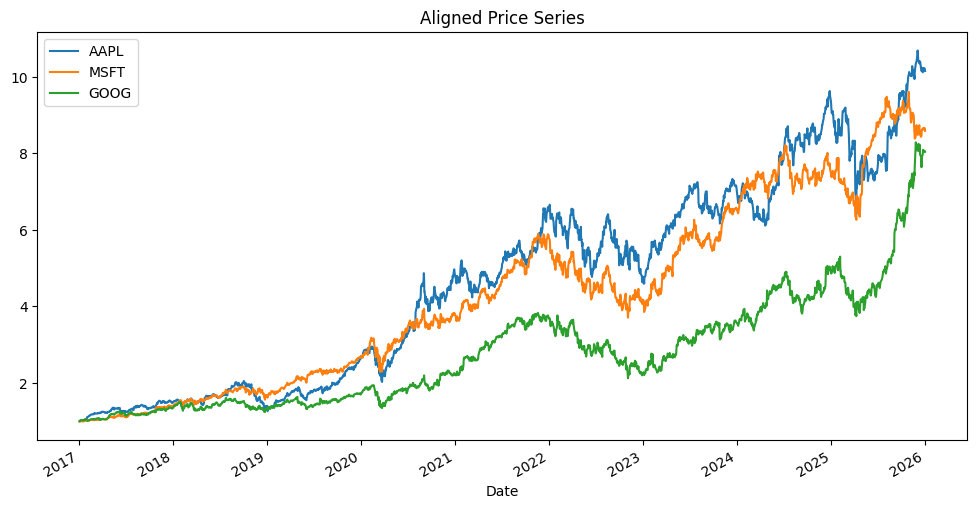

In [7]:
import matplotlib.pyplot as plt

returns = aligned_prices.pct_change().dropna()

# Summary statistics
returns.describe().T[["mean", "std"]]

# Sample plot for 3 random assets
aligned_prices[["AAPL","MSFT","GOOG"]].plot(figsize=(12,6), title="Aligned Price Series")
plt.show()

## Phase 2 Summary

- Defined a realistic, multi-asset trading universe
- Fetched, cleaned, and aligned data from free APIs
- Prepared vectorized-ready time series for research
---

# Phase 3: Statistical Arbitrage Research & Pair Selection

## Objective

- Identify cointegrated and correlated pairs
- Construct spreads and normalize with z-score
- Diagnose mean-reversion properties:
    - ADF test
    - Hurst exponent
    - Half-life
- Prepare a shortlist of tradable pairs for backtesting

## Why Phase 3 Matters

- Cointegration identifies **stable long-term relationships**
- Z-score normalization allows **signal generation on standard deviations**
- Mean-reversion diagnostics ensure **pairs revert predictably**
- Avoids false trades from spurious correlations

## Step 1: Rolling Correlation Filter

- Compute rolling correlations (window=60 days)
- Filter for pairs with consistent correlation > 0.8

In [8]:
# Compute Rolling Correlations for Pairs of Assets
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.pair_selection import rolling_correlation

rolling_corr = rolling_correlation(aligned_prices, window=60)
rolling_corr.iloc[-5:, :5]  # show last 5 rows for first 5 assets

AAPL       AMD      AMZN       CVX      GOOG
Date                                                             
2025-12-31 MSFT  0.232529  0.420134  0.292345 -0.063801  0.057770
           NVDA  0.224340  0.568385  0.448419 -0.025527  0.369036
           PEP  -0.185397 -0.259068 -0.287367 -0.009168 -0.198742
           TSLA  0.255162  0.368882  0.507596  0.054194  0.571659
           XOM   0.163887 -0.048300  0.045317  0.758138 -0.075019

## Step 2: Engle-Granger Cointegration Test

- Identify statistically significant pairs (p < 0.05)
- Only consider pairs that pass both correlation and cointegration

In [9]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.pair_selection import find_cointegrated_pairs

pairs, pvalues = find_cointegrated_pairs(aligned_prices)
print(f"Identified {len(pairs)} cointegrated pairs.")
pairs[:]

Identified 6 cointegrated pairs.


[('AAPL', 'KO', np.float64(0.0481029999479759)),
 ('AAPL', 'MSFT', np.float64(0.038380749641729744)),
 ('AMD', 'MSFT', np.float64(0.04309862063233698)),
 ('AMD', 'TSLA', np.float64(0.0464485039490807)),
 ('KO', 'MSFT', np.float64(0.02148970779638986)),
 ('META', 'NVDA', np.float64(0.029987415226936317))]

## Step 3: Spread Construction & Normalization

- Compute OLS beta for each pair
- Construct spread = S1 - beta * S2
- Normalize spread as z-score for entry/exit signals

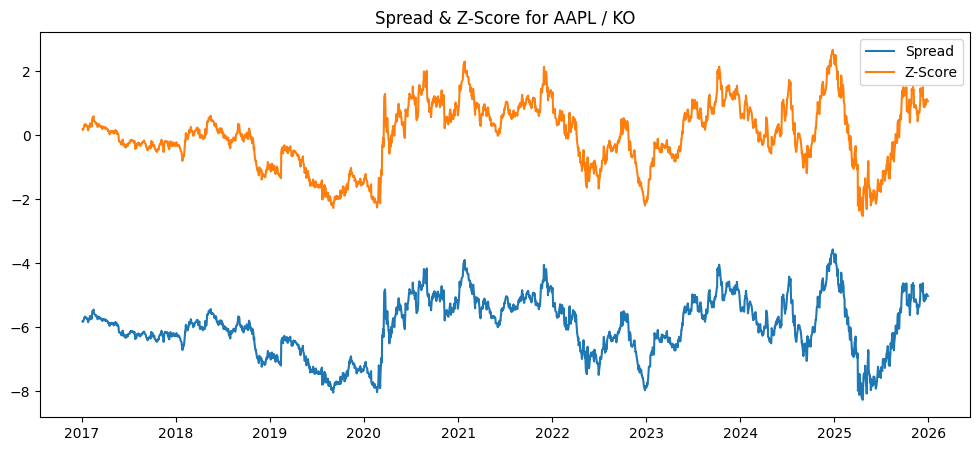

In [10]:
# Compute Spread and Z-score of Top Cointegrated Pair
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.spread import construct_spread

S1, S2 = aligned_prices[pairs[0][0]], aligned_prices[pairs[0][1]]
spread, zscore = construct_spread(S1, S2)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(spread, label="Spread")
plt.plot(zscore, label="Z-Score")
plt.legend()
plt.title(f"Spread & Z-Score for {pairs[0][0]} / {pairs[0][1]}")
plt.show()

## Step 4: Mean Reversion Diagnostics

- **ADF test**: Rejects random walk
- **Hurst exponent**: <0.5 indicates anti-persistent (mean-reverting)
- **Half-life**: Expected holding period of spread

In [11]:
# Compute Diagnostics of Top Pair
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.diagnostics import adf_test, hurst_exponent, half_life

adf_result = adf_test(spread)
hurst = hurst_exponent(spread.values)
hl = half_life(spread.values)

print(f"ADF p-value: {adf_result['p_value']:.4f}")
print(f"Hurst exponent: {hurst:.4f}")
print(f"Estimated half-life: {hl:.2f} days")

ADF p-value: 0.0128
Hurst exponent: 0.9596
Estimated half-life: 66.03 days


## Phase 3 Summary

- Filtered pairs by **rolling correlation and cointegration**
- Constructed spreads and normalized as z-scores
- Calculated **mean-reversion diagnostics** (ADF, Hurst, half-life)
- Prepared a **shortlist of tradable pairs** for Phase 4: Signal Generation
---

# Phase 4: Signal Generation

## Objective

- Generate entry/exit signals from spreads (Phase 3)
- Apply z-score thresholds and dynamic bands
- Implement signal debouncing to avoid overtrading
- Prepare signals for portfolio aggregation

## Why Phase 4 Matters

- Translating spreads into signals is **critical for realistic backtests**
- Overtrading inflates Sharpe ratio; debouncing fixes this
- Time-based exits simulate real-world holding periods
- Signals are the bridge between research and portfolio construction

In [12]:
# Derive Spread and Z-score
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.align import align_assets
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.spread import construct_spread

# Load data
aligned_prices = align_assets()
S1, S2 = aligned_prices[pairs[0][0]], aligned_prices[pairs[0][1]]

# Construct spread and z-score
spread, zscore = construct_spread(S1, S2)
spread.head(), zscore.head()

(Date
 2017-01-03   -5.821764
 2017-01-04   -5.821764
 2017-01-05   -5.833056
 2017-01-06   -5.820229
 2017-01-09   -5.742149
 dtype: float64,
 Date
 2017-01-03    0.188034
 2017-01-04    0.188034
 2017-01-05    0.175554
 2017-01-06    0.189730
 2017-01-09    0.276026
 dtype: float64)

## Step 1: Generate Long/Short Signals

- Enter long when z-score < -entry_threshold
- Enter short when z-score > +entry_threshold
- Exit when z-score returns to |z| < exit_threshold
- Optionally, limit maximum holding period

In [13]:
# Generate Signals
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.signals.signal_generator import generate_signals

signals = generate_signals(zscore, entry_threshold=2.0, exit_threshold=0.5, max_hold=10)
signals.value_counts()

 0    2082
 1     110
-1      70
Name: count, dtype: int64

## Step 2: Visualize Spread and Signals

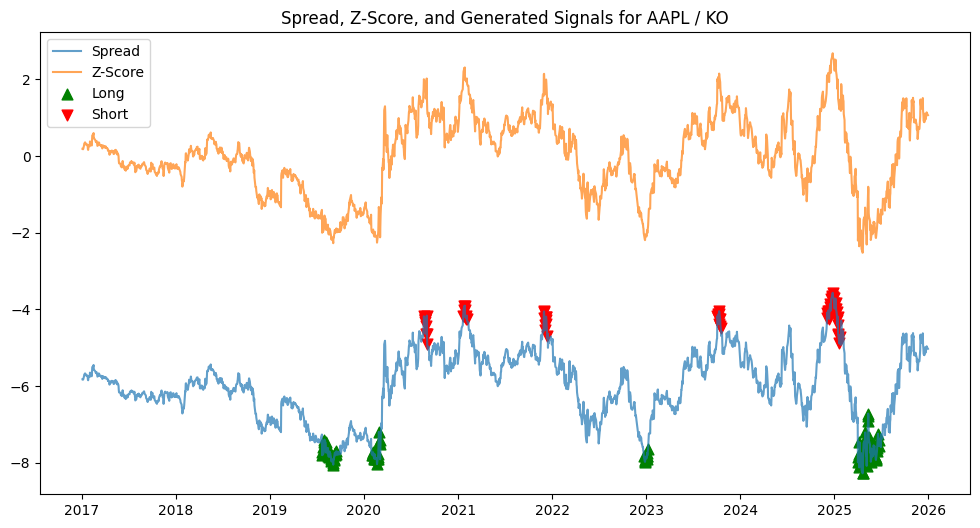

In [14]:
# Plot Spread and Signals
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot spread and z-score (full series)
plt.plot(spread.index, spread, label="Spread", alpha=0.7)
plt.plot(zscore.index, zscore, label="Z-Score", alpha=0.7)

# Plot long signals
long_idx = signals[signals == 1].index
plt.scatter(
    long_idx,
    spread.loc[long_idx],
    color="green",
    marker="^",
    label="Long",
    s=60
)

# Plot short signals
short_idx = signals[signals == -1].index
plt.scatter(
    short_idx,
    spread.loc[short_idx],
    color="red",
    marker="v",
    label="Short",
    s=60
)

# Generate plot
plt.legend()
plt.title(f"Spread, Z-Score, and Generated Signals for {pairs[0][0]} / {pairs[0][1]}")
plt.show()

## Phase 4 Summary

- Signals generated using z-score thresholds
- Signal debouncing prevents unrealistic overtrading
- Optional maximum holding period simulates real trade durations
---

# Phase 5: Portfolio Construction & Capital Allocation

## Objective

- Convert signals (Phase 4) into **position sizes**
- Apply **dollar-neutral, volatility-targeted allocation**
- Aggregate multiple pairs into a **single portfolio**
- Enforce **leverage and exposure constraints**

## Why Phase 5 Matters

- Raw signals are **not enough**; portfolio risk must be managed
- Position sizing avoids concentration in single pairs
- Volatility targeting stabilizes risk over time
- Aggregate portfolio enforces **max leverage** and sector / asset-class exposure

In [15]:
# Load Signals
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.signals.signal_generator import generate_signals
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.spread import construct_spread
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.align import align_assets

# Load aligned data
aligned_prices = align_assets()

# Example pair (Top Cointegrated Pair)
S1, S2 = aligned_prices[pairs[0][0]], aligned_prices[pairs[0][1]]
spread, zscore = construct_spread(S1, S2)
signals = generate_signals(zscore, entry_threshold=2.0, exit_threshold=0.5, max_hold=10)

signals.value_counts()

 0    2082
 1     110
-1      70
Name: count, dtype: int64

## Step 1: Dollar-Neutral Allocation

- Allocate equal capital to long and short legs
- Ensures **no directional bias**

In [16]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.portfolio.allocation import dollar_neutral_allocation

positions = dollar_neutral_allocation(signals, capital=100000)
print(positions)
print(positions.value_counts())

Date
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
2017-01-06    0.0
2017-01-09    0.0
             ... 
2025-12-24    0.0
2025-12-26    0.0
2025-12-29    0.0
2025-12-30    0.0
2025-12-31    0.0
Length: 2262, dtype: float64
 0.000000      2082
 454.545455     110
-714.285714      70
Name: count, dtype: int64


## Step 2: Volatility Targeting

- Scale positions to achieve **target daily volatility**
- Stabilizes risk across volatile pairs

In [17]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.portfolio.allocation import volatility_targeting

positions_vol = volatility_targeting(signals, S1, target_vol=0.02)
positions_vol

Date
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
2017-01-06    0.0
2017-01-09    0.0
             ... 
2025-12-24    0.0
2025-12-26    0.0
2025-12-29    0.0
2025-12-30    0.0
2025-12-31    0.0
Length: 2262, dtype: float64

## Step 3: Portfolio Aggregation

- Multiple pairs are combined
- Leverage and exposure limits are enforced
- Output is a **single series representing total portfolio position**

In [18]:
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.portfolio.portfolio_manager import PortfolioManager

pm = PortfolioManager(max_leverage=3.0)
pm.add_pair(f"{pairs[0][0]} / {pairs[0][1]}", positions_vol)

# Example: add a second pair (Google & Amazon)
S3, S4 = aligned_prices["GOOG"], aligned_prices["AMZN"]
spread2, zscore2 = construct_spread(S3, S4)
signals2 = generate_signals(zscore2, entry_threshold=2.0, exit_threshold=0.5, max_hold=10)
positions2_vol = volatility_targeting(signals2, S3, target_vol=0.02)
pm.add_pair("GOOG/AMZN", positions2_vol)

portfolio = pm.aggregate()
portfolio.value_counts()

 0.000000    1925
 3.000000     201
-3.000000     127
-0.527015       9
Name: count, dtype: int64

## Phase 5 Summary

- Signals converted into **risk-adjusted positions**
- Dollar-neutral and volatility-targeted allocation applied
- Multiple pairs aggregated into **single portfolio**
- Leverage constraints enforced
---

# Phase 6: Execution & Market Frictions

## Objective

- Apply **transaction costs, bid-ask spreads, slippage**
- Simulate **position rebalancing** frequency
- Ensure **realistic PnL calculation**

## Why Phase 6 Matters

- Ignoring frictions leads to **inflated Sharpe ratios** and unrealistic results
- Rebalancing simulates **actual trading operations**
- Slippage proportional to volatility reflects **real market behavior**
- Prepares portfolio for **risk-adjusted backtesting**

In [19]:
# Load Portfolio Positions
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.portfolio.portfolio_manager import PortfolioManager
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.portfolio.allocation import volatility_targeting
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.signals.signal_generator import generate_signals
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.research.spread import construct_spread
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.data.align import align_assets

# Load aligned data
aligned_prices = align_assets()

# Example pair: Top Cointegrated Pair
S1, S2 = aligned_prices[pairs[0][0]], aligned_prices[pairs[0][1]]
spread, zscore = construct_spread(S1, S2)
signals = generate_signals(zscore, entry_threshold=2.0, exit_threshold=0.5, max_hold=10)
positions = volatility_targeting(signals, S1, target_vol=0.02)
positions.value_counts()

 0.000000      2082
 487.187419     110
-765.580230      70
Name: count, dtype: int64

## Step 1: Rebalance Positions

- Reduce unnecessary daily trading
- Rebalance every 5 days (can adjust)

In [20]:
# Rebalance Example
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.execution.rebalance import rebalance_positions

positions_reb = rebalance_positions(positions, freq=5)
positions_reb.value_counts()

 0.000000      2082
 487.187419     110
-765.580230      70
Name: count, dtype: int64

## Step 2: Apply Execution Costs and Slippage

- Transaction costs per trade
- Bid-ask spread impact
- Slippage proportional to volatility

In [21]:
# Execution Adjusted Prices
from Multi_Asset_Stat_Arb_Backtesting_Engine.main.execution.execution_model import ExecutionModel

exec_model = ExecutionModel(transaction_cost=0.0005, bid_ask_spread=0.0002, slippage_vol_factor=0.1)
effective_prices = exec_model.apply(positions_reb, S1)
effective_prices

Date
2017-01-03     0.998881
2017-01-04     0.998881
2017-01-05     1.003960
2017-01-06     1.015153
2017-01-09     1.024451
                ...    
2025-12-24    10.227904
2025-12-26    10.212588
2025-12-29    10.226036
2025-12-30    10.200635
2025-12-31    10.155063
Length: 2262, dtype: float64

## Phase 6 Summary

- Positions are rebalanced to realistic trading frequency
- Transaction costs, bid-ask spread, and slippage applied
- Portfolio PnL now reflects **real-world trading conditions**
---